In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the optimized CNN-LSTM model
def create_optimized_cnn_lstm_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', 
               kernel_regularizer=l2(0.005), input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        LSTM(32, dropout=0.4, recurrent_dropout=0.2),
        
        Dense(32, activation='relu', kernel_regularizer=l2(0.005)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax', dtype='float32')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [3]:
# Data augmentation (unchanged from original)
def data_augmentation(X, y):
    """Apply data augmentation to increase dataset size and variety"""
    try:
        print(f"Input shape before augmentation: {X.shape}")
        X_augmented = [X]
        y_augmented = [y]
        
        # Adding random noise
        noise_factor = 0.05
        X_noise = X + np.random.normal(0, noise_factor, X.shape)
        X_augmented.append(X_noise)
        y_augmented.append(y)
        
        # Magnitude scaling
        scale_factor = np.random.uniform(0.8, 1.2)
        X_scaled = X * scale_factor
        X_augmented.append(X_scaled)
        y_augmented.append(y)
        
        # Time shifting (ensure compatibility with 3D input)
        shift = np.random.randint(1, 3)
        X_shifted = np.roll(X, shift, axis=1)
        X_augmented.append(X_shifted)
        y_augmented.append(y)
        
        # Combine augmented data
        X_aug = np.vstack(X_augmented)
        y_aug = np.hstack(y_augmented)
        
        # Shuffle the augmented data
        indices = np.arange(X_aug.shape[0])
        np.random.shuffle(indices)
        X_aug = X_aug[indices]
        y_aug = y_aug[indices]
        
        print(f"Output shape after augmentation: {X_aug.shape}")
        return X_aug, y_aug
    except Exception as e:
        print(f"Error in data_augmentation: {e}")
        raise



In [4]:
# Feature selection
def select_features(X, y, k=50):
    """Select top k features using ANOVA F-value"""
    try:
        selector = SelectKBest(score_func=f_classif, k=k)
        X_selected = selector.fit_transform(X, y)
        selected_indices = selector.get_support(indices=True)
        return X_selected, selected_indices
    except Exception as e:
        print(f"Error in select_features: {e}")
        raise


In [5]:
def preprocess_data(X, y, test_size=0.2, val_size=0.2, k_features=50):
    """Preprocess data: feature selection, scale features, and split into train, test, validation sets"""
    try:
        print(f"Input X shape: {X.shape}, y shape: {y.shape}")
        
        # Feature selection
        X_selected, selected_indices = select_features(X, y, k=k_features)
        print(f"Shape after feature selection: {X_selected.shape}")
        
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=test_size, 
                                                            stratify=y, random_state=42)
        
        # Split train set into train and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, 
                                                          stratify=y_train, random_state=42)
        
        # Scale the features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)
        
        # Reshape for CNN (samples, timesteps, features)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        
        print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")
        return X_train, X_val, X_test, y_train, y_val, y_test, scaler, selected_indices
    except Exception as e:
        print(f"Error in preprocess_data: {e}")
        raise


In [6]:
# Train the model
def train_model(X_train, y_train, X_val, y_val, input_shape, num_classes, 
                batch_size=128, epochs=30):
    """Train the optimized CNN-LSTM model"""
    try:
        print(f"Input shapes - X_train: {X_train.shape}, y_train: {y_train.shape}, X_val: {X_val.shape}")
        print(f"Expected input shape for model: {input_shape}, num_classes: {num_classes}")
        
        # Validate input shapes
        if X_train.shape[1:] != input_shape:
            raise ValueError(f"X_train shape {X_train.shape[1:]} does not match input_shape {input_shape}")
        
        # Apply data augmentation
        X_train_aug, y_train_aug = data_augmentation(X_train, y_train)
        
        # Calculate class weights
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weight_dict = dict(enumerate(class_weights))
        print(f"Class weights: {class_weight_dict}")
        
        # Create model
        model = create_optimized_cnn_lstm_model(input_shape, num_classes)
        model.summary()
        
        # Define callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1),
            ModelCheckpoint('best_optimized_cnn_lstm.h5', monitor='val_loss', save_best_only=True, verbose=1)
        ]
        
        # Train the model
        history = model.fit(
            X_train_aug, y_train_aug,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            class_weight=class_weight_dict,
            verbose=1
        )
        
        return model, history
    except Exception as e:
        print(f"Error in train_model: {e}")
        raise


In [7]:

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    """Evaluate model performance and visualize results"""
    try:
        y_pred_prob = model.predict(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        
        print('\nClassification Report:')
        print(classification_report(y_test, y_pred))
        
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        test_loss, test_accuracy = model.evaluate(X_test, y_test)
        print(f"Test accuracy: {test_accuracy:.4f}")
    except Exception as e:
        print(f"Error in evaluate_model: {e}")
        raise


In [8]:
# Plot training history
def plot_training_history(history):
    """Plot training and validation metrics"""
    try:
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in plot_training_history: {e}")
        raise


Dataset loaded with shape: (746117, 79)
Encoded labels: [0 1 2 3 4 5]
Input X shape: (746117, 78), y shape: (746117,)


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [31 33 56 57 58 59 60 61] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Shape after feature selection: (746117, 50)
X_train shape: (477514, 50, 1), X_val shape: (119379, 50, 1), X_test shape: (149224, 50, 1)
Training set shape: (477514, 50, 1)
Validation set shape: (119379, 50, 1)
Test set shape: (149224, 50, 1)
Number of classes: 6
Selected feature indices: [ 0  1  4  6  7  8  9 10 11 12 13 15 16 17 18 20 21 22 23 25 26 27 28 30
 36 37 38 39 40 41 42 43 44 46 47 48 51 52 53 54 63 66 67 70 72 73 74 75
 76 77]
Class distribution in training set: [192000  65550 129362   1013  88455   1134]
Input shapes - X_train: (477514, 50, 1), y_train: (477514,), X_val: (119379, 50, 1)
Expected input shape for model: (50, 1), num_classes: 6
Input shape before augmentation: (477514, 50, 1)
Output shape after augmentation: (1910056, 50, 1)
Class weights: {0: np.float64(0.41450868055555556), 1: np.float64(1.2141215357233663), 2: np.float64(0.6152167303123535), 3: np.float64(78.56433037183284), 4: np.float64(0.8997305597949994), 5: np.float64(70.18136390358613)}


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 48, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,958 (38.90 KB)

 Trainable params: 9,830 (38.40 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/30
14921/14923 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5500 - loss: 1.1632
Epoch 1: val_loss improved from inf to 0.45247, saving model to best_optimized_cnn_lstm.h5


14923/14923 ━━━━━━━━━━━━━━━━━━━━ 132s 9ms/step - accuracy: 0.5500 - loss: 1.1631 - val_accuracy: 0.8491 - val_loss: 0.4525 - learning_rate: 5.0000e-04
Epoch 2/30
14920/14923 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8430 - loss: 0.3651
Epoch 2: val_loss improved from 0.45247 to 0.30316, saving model to best_optimized_cnn_lstm.h5


14923/14923 ━━━━━━━━━━━━━━━━━━━━ 124s 8ms/step - accuracy: 0.8430 - loss: 0.3651 - val_accuracy: 0.8982 - val_loss: 0.3032 - learning_rate: 5.0000e-04
Epoch 3/30
14923/14923 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8808 - loss: 0.2767
Epoch 3: val_loss improved from 0.30316 to 0.26403, saving model to best_optimized_cnn_lstm.h5


14923/14923 ━━━━━━━━━━━━━━━━━━━━ 125s 8ms/step - accuracy: 0.8808 - loss: 0.2767 - val_accuracy: 0.9240 - val_loss: 0.2640 - learning_rate: 5.0000e-04
Epoch 4/30
14920/14923 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8981 - loss: 0.2427
Epoch 4: val_loss improved from 0.26403 to 0.25588, saving model to best_optimized_cnn_lstm.h5


14923/14923 ━━━━━━━━━━━━━━━━━━━━ 128s 9ms/step - accuracy: 0.8981 - loss: 0.2427 - val_accuracy: 0.9304 - val_loss: 0.2559 - learning_rate: 5.0000e-04
Epoch 5/30
14923/14923 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9051 - loss: 0.2297
Epoch 5: val_loss did not improve from 0.25588
14923/14923 ━━━━━━━━━━━━━━━━━━━━ 129s 9ms/step - accuracy: 0.9051 - loss: 0.2297 - val_accuracy: 0.9287 - val_loss: 0.2649 - learning_rate: 5.0000e-04
Epoch 6/30
14918/14923 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9122 - loss: 0.2138
Epoch 6: val_loss improved from 0.25588 to 0.23513, saving model to best_optimized_cnn_lstm.h5


14923/14923 ━━━━━━━━━━━━━━━━━━━━ 130s 9ms/step - accuracy: 0.9122 - loss: 0.2138 - val_accuracy: 0.9371 - val_loss: 0.2351 - learning_rate: 5.0000e-04
Epoch 7/30
14920/14923 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9155 - loss: 0.2072
Epoch 7: val_loss did not improve from 0.23513
14923/14923 ━━━━━━━━━━━━━━━━━━━━ 130s 9ms/step - accuracy: 0.9155 - loss: 0.2072 - val_accuracy: 0.9367 - val_loss: 0.2407 - learning_rate: 5.0000e-04
Epoch 8/30
14920/14923 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9187 - loss: 0.1984
Epoch 8: val_loss improved from 0.23513 to 0.20755, saving model to best_optimized_cnn_lstm.h5


14923/14923 ━━━━━━━━━━━━━━━━━━━━ 130s 9ms/step - accuracy: 0.9187 - loss: 0.1984 - val_accuracy: 0.9434 - val_loss: 0.2075 - learning_rate: 5.0000e-04
Epoch 9/30
14919/14923 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9222 - loss: 0.1922
Epoch 9: val_loss did not improve from 0.20755
14923/14923 ━━━━━━━━━━━━━━━━━━━━ 131s 9ms/step - accuracy: 0.9222 - loss: 0.1922 - val_accuracy: 0.9421 - val_loss: 0.2156 - learning_rate: 5.0000e-04
Epoch 10/30
14920/14923 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9226 - loss: 0.1906
Epoch 10: val_loss did not improve from 0.20755
14923/14923 ━━━━━━━━━━━━━━━━━━━━ 129s 9ms/step - accuracy: 0.9226 - loss: 0.1906 - val_accuracy: 0.9426 - val_loss: 0.2153 - learning_rate: 5.0000e-04
Epoch 11/30
14920/14923 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9255 - loss: 0.1861
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 11: val_loss did not improve from 0.20755
14923/14923 ━━━━━━━━━━━━━━━━━━━━ 132s 9ms/step - accu

14923/14923 ━━━━━━━━━━━━━━━━━━━━ 132s 9ms/step - accuracy: 0.9293 - loss: 0.1759 - val_accuracy: 0.9458 - val_loss: 0.2025 - learning_rate: 1.0000e-04
Epoch 13/30
14919/14923 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9337 - loss: 0.1619
Epoch 13: val_loss did not improve from 0.20249
14923/14923 ━━━━━━━━━━━━━━━━━━━━ 131s 9ms/step - accuracy: 0.9337 - loss: 0.1619 - val_accuracy: 0.9449 - val_loss: 0.2030 - learning_rate: 1.0000e-04
Epoch 14/30
14918/14923 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9342 - loss: 0.1581
Epoch 14: val_loss improved from 0.20249 to 0.19487, saving model to best_optimized_cnn_lstm.h5


14923/14923 ━━━━━━━━━━━━━━━━━━━━ 132s 9ms/step - accuracy: 0.9342 - loss: 0.1581 - val_accuracy: 0.9465 - val_loss: 0.1949 - learning_rate: 1.0000e-04
Epoch 15/30
14923/14923 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9347 - loss: 0.1557
Epoch 15: val_loss did not improve from 0.19487
14923/14923 ━━━━━━━━━━━━━━━━━━━━ 136s 9ms/step - accuracy: 0.9347 - loss: 0.1557 - val_accuracy: 0.9465 - val_loss: 0.1953 - learning_rate: 1.0000e-04
Epoch 16/30
14923/14923 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9340 - loss: 0.1613
Epoch 16: val_loss did not improve from 0.19487
14923/14923 ━━━━━━━━━━━━━━━━━━━━ 135s 9ms/step - accuracy: 0.9340 - loss: 0.1613 - val_accuracy: 0.9463 - val_loss: 0.1986 - learning_rate: 1.0000e-04
Epoch 17/30
14918/14923 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9351 - loss: 0.1554
Epoch 17: val_loss improved from 0.19487 to 0.17961, saving model to best_optimized_cnn_lstm.h5


14923/14923 ━━━━━━━━━━━━━━━━━━━━ 133s 9ms/step - accuracy: 0.9351 - loss: 0.1554 - val_accuracy: 0.9486 - val_loss: 0.1796 - learning_rate: 1.0000e-04
Epoch 18/30
14918/14923 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9362 - loss: 0.1496
Epoch 18: val_loss did not improve from 0.17961
14923/14923 ━━━━━━━━━━━━━━━━━━━━ 136s 9ms/step - accuracy: 0.9362 - loss: 0.1496 - val_accuracy: 0.9477 - val_loss: 0.1892 - learning_rate: 1.0000e-04
Epoch 19/30
14922/14923 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9351 - loss: 0.1531
Epoch 19: val_loss did not improve from 0.17961
14923/14923 ━━━━━━━━━━━━━━━━━━━━ 136s 9ms/step - accuracy: 0.9351 - loss: 0.1531 - val_accuracy: 0.9475 - val_loss: 0.1860 - learning_rate: 1.0000e-04
Epoch 20/30
14919/14923 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9354 - loss: 0.1528
Epoch 20: val_loss improved from 0.17961 to 0.17816, saving model to best_optimized_cnn_lstm.h5


14923/14923 ━━━━━━━━━━━━━━━━━━━━ 136s 9ms/step - accuracy: 0.9354 - loss: 0.1528 - val_accuracy: 0.9490 - val_loss: 0.1782 - learning_rate: 1.0000e-04
Epoch 21/30
14920/14923 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9360 - loss: 0.1525
Epoch 21: val_loss did not improve from 0.17816
14923/14923 ━━━━━━━━━━━━━━━━━━━━ 137s 9ms/step - accuracy: 0.9360 - loss: 0.1525 - val_accuracy: 0.9486 - val_loss: 0.1806 - learning_rate: 1.0000e-04
Epoch 22/30
14923/14923 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9354 - loss: 0.1511
Epoch 22: val_loss did not improve from 0.17816
14923/14923 ━━━━━━━━━━━━━━━━━━━━ 139s 9ms/step - accuracy: 0.9354 - loss: 0.1511 - val_accuracy: 0.9474 - val_loss: 0.1853 - learning_rate: 1.0000e-04
Epoch 23/30
14919/14923 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9356 - loss: 0.1502
Epoch 23: ReduceLROnPlateau reducing learning rate to 2.0000000949949027e-05.

Epoch 23: val_loss did not improve from 0.17816
14923/14923 ━━━━━━━━━━━━━━━━━━━━ 138s 9ms/step - ac

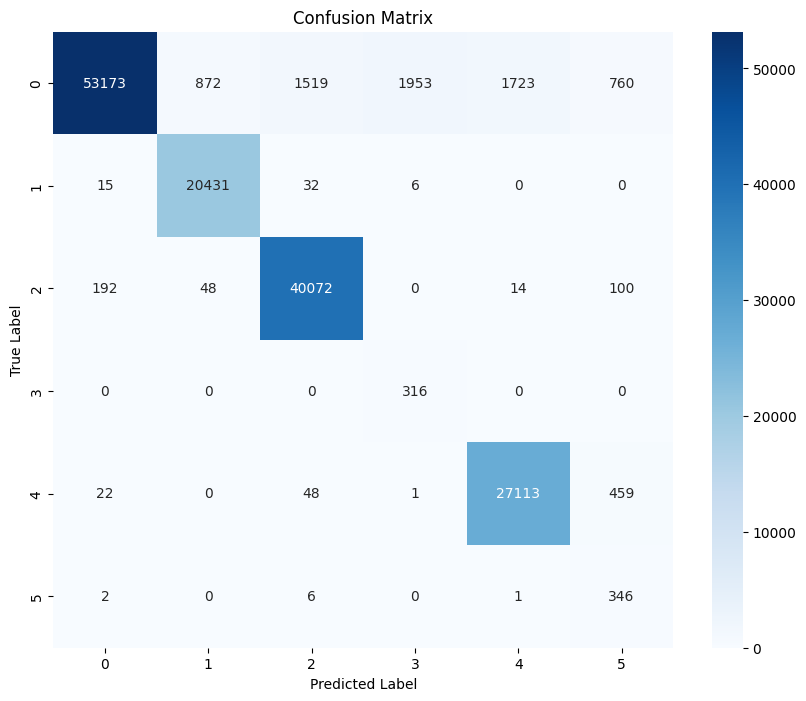

4664/4664 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9485 - loss: 0.1800
Test accuracy: 0.9479


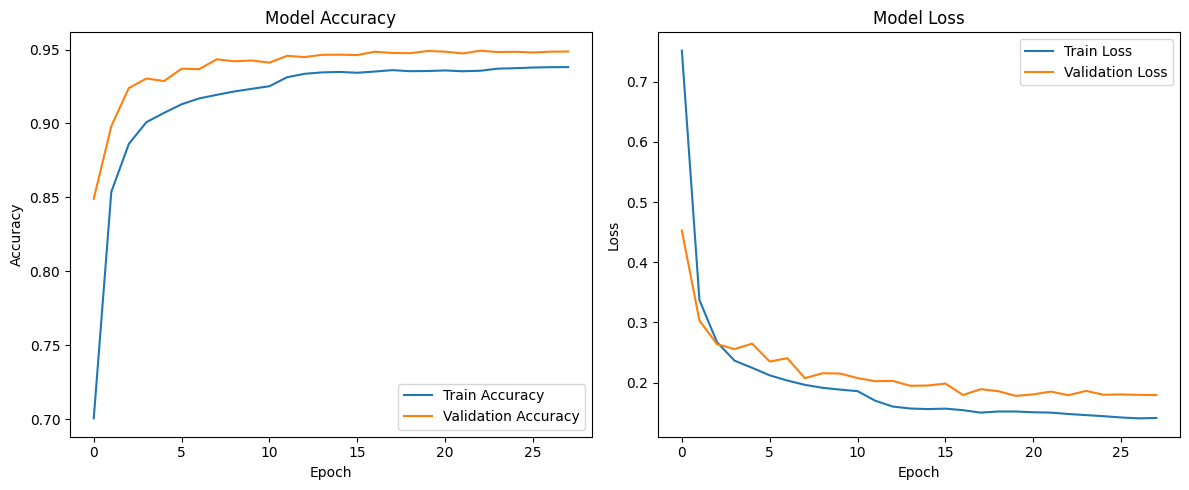

Saved scaler_optimized.pkl, label_encoder_optimized.pkl, and selected_indices.pkl


In [13]:
# Main function
def main():
    try:
        # Load dataset
        path = r'C:\Users\ASUS\Desktop\PBL\data\resampled_dataset.csv'
        df = pd.read_csv(path)
        print(f"Dataset loaded with shape: {df.shape}")
        
        # Define mapping dictionary
        label_mapping = {
        'BENIGN': 'Benign Traffic',
        'DoS Hulk': 'DoS Attacks',
        'DoS GoldenEye': 'DoS Attacks',
        'DoS slowloris': 'DoS Attacks',
        'DoS Slowhttptest': 'DoS Attacks',
        'DDoS': 'DDoS Attacks',
        'PortScan': 'Port Scanning & Brute Force',
        'FTP-Patator': 'Port Scanning & Brute Force',
        'SSH-Patator': 'Port Scanning & Brute Force',
        'Web Attack – Brute Force': 'Web-Based Attacks',
        'Web Attack – XSS': 'Web-Based Attacks',
        'Web Attack – Sql Injection': 'Web-Based Attacks',
        'Bot': 'Other Exploits & Infiltrations',
        ' Infiltration': 'Other Exploits & Infiltrations',
        'Heartbleed': 'Other Exploits & Infiltrations'
        }

        # Apply mapping to create a new column with grouped labels
        df['Label'] = df['Label'].map(label_mapping)
        df['Label'].value_counts()
        
        
        
        # Encode labels
        label_encoder = LabelEncoder()
        df['Label'] = label_encoder.fit_transform(df['Label'])
        print(f"Encoded labels: {np.unique(df['Label'])}")
        
        # Handle infinities and NaNs
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(df.mean(numeric_only=True), inplace=True)
        
        # Normalize features
        scaler = MinMaxScaler()
        X = df.drop(columns=['Label']).values
        X_scaled = scaler.fit_transform(X)
        y = df['Label'].values
        
        # Preprocess data with feature selection
        X_train, X_val, X_test, y_train, y_val, y_test, scaler, selected_indices = preprocess_data(
            X_scaled, y, k_features=50
        )
        
        # Get input shape and number of classes
        input_shape = (X_train.shape[1], X_train.shape[2])
        num_classes = len(np.unique(y))
        
        # Print dataset info
        print(f"Training set shape: {X_train.shape}")
        print(f"Validation set shape: {X_val.shape}")
        print(f"Test set shape: {X_test.shape}")
        print(f"Number of classes: {num_classes}")
        print(f"Selected feature indices: {selected_indices}")
        print("Class distribution in training set:", np.bincount(y_train))
        
        #Train the model
        model, history = train_model(X_train, y_train, X_val, y_val, input_shape, num_classes)
        
        # Evaluate and visualize results
        evaluate_model(model, X_test, y_test)
        plot_training_history(history)
        
        # Save scaler, label encoder, and selected indices
        joblib.dump(scaler, 'scaler_optimized.pkl')
        joblib.dump(label_encoder, 'label_encoder_optimized.pkl')
        joblib.dump(selected_indices, 'selected_indices.pkl')
        print("Saved scaler_optimized.pkl, label_encoder_optimized.pkl, and selected_indices.pkl")
    except Exception as e:
        print(f"Error in main: {e}")
        raise

if __name__ == "__main__":
    main()